In [ ]:
pip install librosa soundfile transformers pytorch HDBScan umap matplotlib umap-learn sentence-transformers

In [93]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Set the random seed for reproducibility
np.random.seed(42)

In [94]:
# Define the directory where the RAVDESS audio files are stored.
# Adjust this path to the location of your dataset.
audio_dir = "data/"

# Get a list of all audio file paths
audio_files = []
for root, dirs, files in os.walk(audio_dir):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))

print(f"Found {len(audio_files)} audio files.")

Found 8882 audio files.


# Our New Approach of an SLM-Based Lexical-Paralinguistics Hybrid Approach  

## Transcription of audio 

In [95]:
import torch
import librosa
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load the pretrained Wav2Vec2 model and processor
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
def transcribe_audio(file_path):
    """
    Transcribe an audio file using the Wav2Vec2 model.
    Assumes audio is in English and resampled to 16000 Hz.
    """
    # Load audio file; librosa loads as float32 and downmixes to mono automatically
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Process audio to get input values for the model
    input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
    
    # Get logits from the model
    with torch.no_grad():
        logits = model(input_values).logits

    # Decode the logits to get transcription; use argmax decoding here (can be replaced with beam search if needed)
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    
    return transcription

In [97]:
# Example: transcribe a single file
transcript = transcribe_audio(audio_files[0])
print("Transcript:", transcript)

Transcript: KIDS ARE TALKING BY THE DOOR


In [98]:
transcripts = []
for file in audio_files:    try:
        t = transcribe_audio(file)
        transcripts.append(t)
    except Exception as e:
        print(f"Error transcribing {file}: {e}")
        transcripts.append("")  # Append an empty string if there is an error

# Now you have a 'transcripts' list in the same order as your audio_files and feature extraction.

### Exraction of Paralinguistic cues

In [99]:
# Paralinguistic Feature Extraction using librosa 
def extract_paralinguistic_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)
        zcr_std = np.std(zcr)
        features = np.concatenate([mfccs_mean, mfccs_std, [zcr_mean, zcr_std]])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

paralinguistic_features_list = []
file_names = []  # track file names

for file in audio_files:
    feat = extract_paralinguistic_features(file)
    if feat is not None:
        paralinguistic_features_list.append(feat)
        file_names.append(file)
paralinguistic_features = np.array(paralinguistic_features_list)
print("Paralinguistic features shape:", paralinguistic_features.shape) 

Paralinguistic features shape: (8882, 28)


In [100]:
# Initialize the SentenceTransformer (a small model suitable for our case)
slm_model = SentenceTransformer("all-MiniLM-L6-v2")  # a compact SLM

# Obtain embeddings for the transcripts (lexical features)
lexical_features = slm_model.encode(transcripts)
print("Lexical features shape:", lexical_features.shape)

Lexical features shape: (8882, 384)


In [101]:
# ------------- Feature Fusion -------------
# For a simple fusion, we concatenate the paralinguistic and lexical features.
# You may want to experiment with weighting and dimensionality reduction before fusion.
fused_features = np.concatenate([paralinguistic_features, lexical_features], axis=1)
print("Fused features shape:", fused_features.shape)

Fused features shape: (8882, 412)


Reduced fused features shape: (8882, 2)


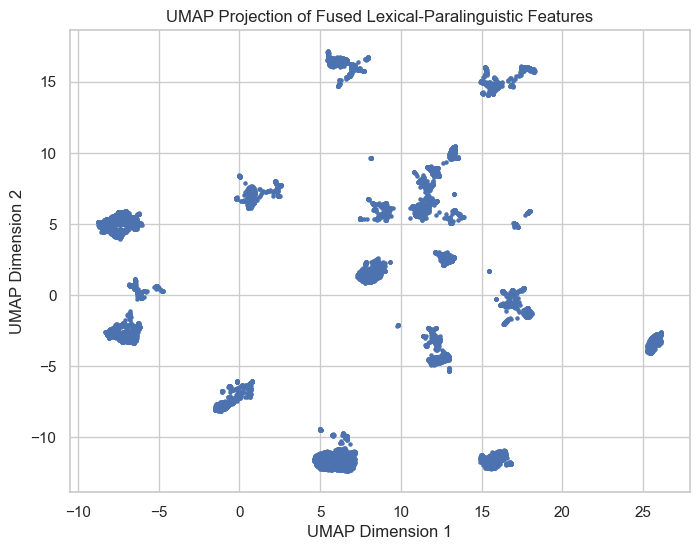

In [102]:
# ------------- Standardize and Reduce Dimensionality -------------
scaler = StandardScaler()
features_scaled = scaler.fit_transform(fused_features)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
features_umap = reducer.fit_transform(features_scaled)
print("Reduced fused features shape:", features_umap.shape)

plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], s=5, cmap="Spectral")
plt.title("UMAP Projection of Fused Lexical-Paralinguistic Features")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show() 

Silhouette Score: 0.5590


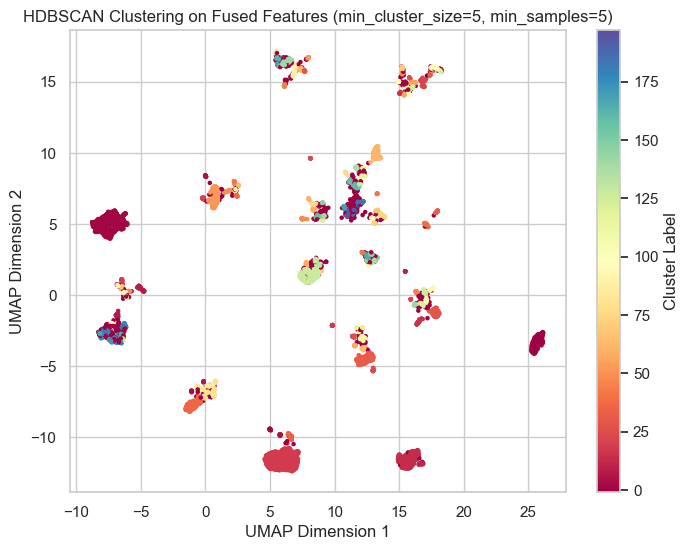

In [103]:
# Assume features_umap is your UMAP-reduced fused feature matrix
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
hdbscan_labels = clusterer.fit_predict(features_umap)

# Exclude noise points (label = -1)
valid_idx = hdbscan_labels != -1

# Check if there are enough valid clusters
if len(set(hdbscan_labels[valid_idx])) > 1:
    librosa_hdbscan_score = silhouette_score(features_umap[valid_idx], hdbscan_labels[valid_idx])
    librosa_hdbscan_db = davies_bouldin_score(features_umap[valid_idx], hdbscan_labels[valid_idx])
    librosa_hsbscan_ch = calinski_harabasz_score(features_umap[valid_idx], hdbscan_labels[valid_idx])
    print(f"Silhouette Score: {librosa_hdbscan_score:.4f}")
    print(f"Davies-Bouldin Index: {librosa_hdbscan_db:.4f}") 
    print(f"Calinski-Harabasz Index: {librosa_hsbscan_ch:.4f}") 

else:
    print("Not enough clusters to compute Silhouette Score.")

# Visualize the clustering
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(features_umap[:, 0], features_umap[:, 1], c=hdbscan_labels, cmap="Spectral", s=5)
plt.title("HDBSCAN Clustering on Fused Features (min_cluster_size=5, min_samples=5)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show() 

In [104]:
import numpy as np

# Get all labels assigned by HDBSCAN
labels = hdbscan_labels

# Count clusters (excluding label -1 which is noise)
unique_clusters = np.unique(labels[labels != -1])
num_clusters = len(unique_clusters)

# Also count how many noise points
num_noise_points = np.sum(labels == -1)
noise_ratio = num_noise_points / len(labels)

print(f"Number of clusters (excluding noise): {num_clusters}")
print(f"Number of noise points: {num_noise_points}")
print(f"Noise ratio: {noise_ratio:.2%}")

Number of clusters (excluding noise): 198
Number of noise points: 822
Noise ratio: 9.25%


Small improvement is made to the Silhoutte Score after using SLM Approach, Noise Ratio and Noise Points has descreased too. Number of clusters exclusing noise is lower as well. This is very promising as it seems that our SLM + paralinguistic representation is caputing structutre that wasn't as clearly seperable as before. Lets Look at how we might be able to push this further. 

Ways to improve :  
- CLS Token Embedding ?
- Weighted Pooling
- Sentence-Level Embedding
- Improve Fusion of features, smarter fusion might help. Can try PCA or autoencoder

# Improvement Part 1 : Comparison of other models for Lexical Features  
- Bert ( Bidrectional Encoder Representations from transformers )
- DistilBERT (Distilled BERT):
- RoBERTa (A Robustly Optimized BERT Pretraining Approach):

In [105]:
from transformers import BertTokenizer, BertModel
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import RobertaTokenizer, RobertaModel

# BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embeddings(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = bert_model(**inputs)
    # Extract [CLS] token embedding and reshape to (1, embedding_dim)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

# DistilBERT model and tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

def get_distilbert_embeddings(text):
    inputs = distilbert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = distilbert_model(**inputs)
    # Extract [CLS] token embedding
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

# RoBERTa model and tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = RobertaModel.from_pretrained("roberta-base")

def get_roberta_embeddings(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = roberta_model(**inputs)
    # Extract [CLS] token embedding
    return outputs.last_hidden_state[:, 0, :].detach().numpy()

# Get embeddings for all transcripts
bert_features = np.array([get_bert_embeddings(transcript) for transcript in transcripts])
distilbert_features = np.array([get_distilbert_embeddings(transcript) for transcript in transcripts])
roberta_features = np.array([get_roberta_embeddings(transcript) for transcript in transcripts])

# Now, these are 2D arrays (samples, features) and can be scaled
print("BERT Lexical Features Shape:", bert_features.shape)
print("DistilBERT Lexical Features Shape:", distilbert_features.shape)
print("RoBERTa Lexical Features Shape:", roberta_features.shape)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Lexical Features Shape: (8882, 1, 768)
DistilBERT Lexical Features Shape: (8882, 1, 768)
RoBERTa Lexical Features Shape: (8882, 1, 768)


BERT Silhouette Score: 0.8174
DistilBERT Silhouette Score: 0.8097
RoBERTa Silhouette Score: 0.7521


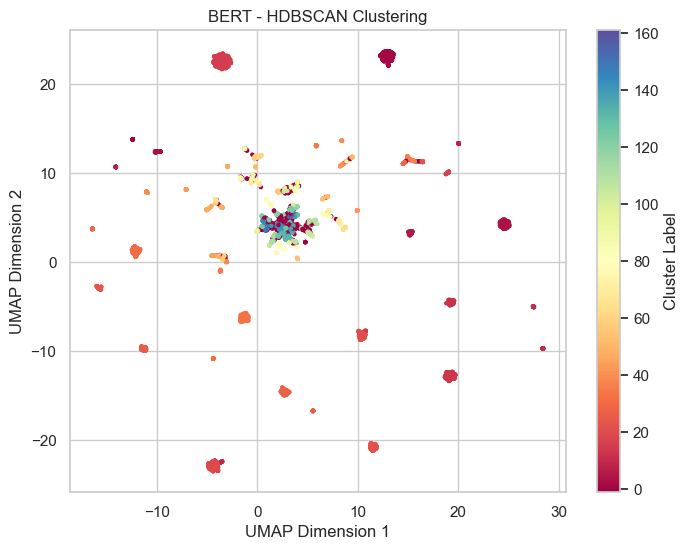

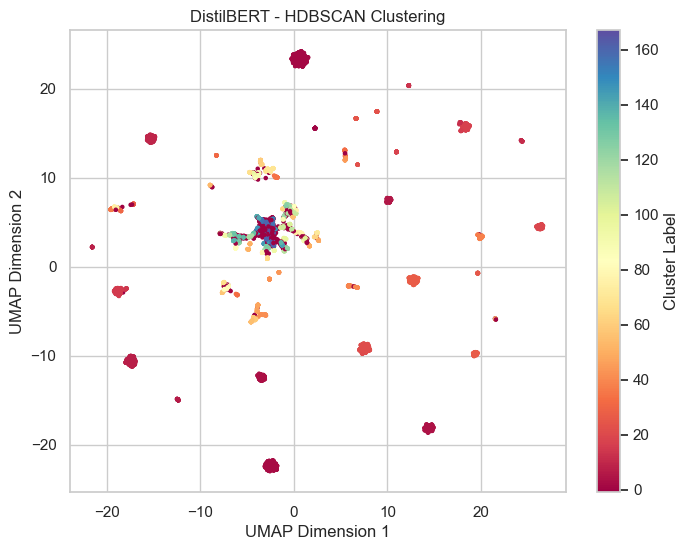

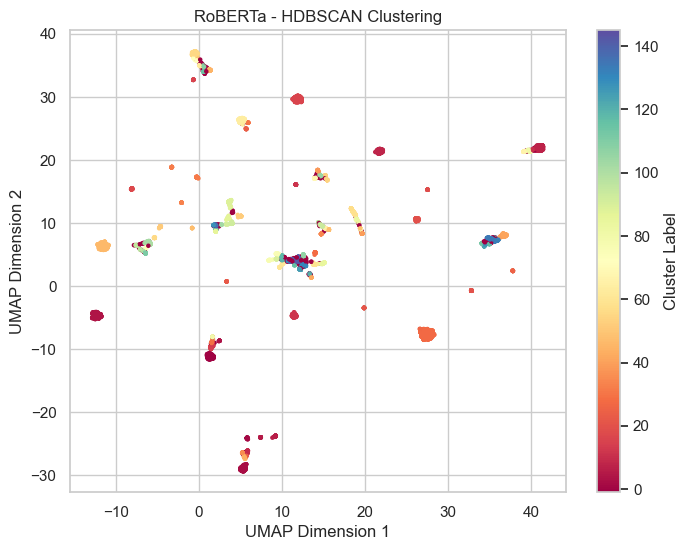

In [106]:
import numpy as np
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming the features from all models (BERT, DistilBERT, RoBERTa) are available as numpy arrays
# Let's assume the variables: bert_features, distilbert_features, roberta_features are available

# Reshape the embeddings to 2D: (samples, embedding_dim) by squeezing the sequence dimension
bert_features_reshaped = bert_features.squeeze(axis=1)  # Remove the sequence dimension
distilbert_features_reshaped = distilbert_features.squeeze(axis=1)
roberta_features_reshaped = roberta_features.squeeze(axis=1)

# Now, scale the reshaped features
scaler = StandardScaler()

bert_scaled = scaler.fit_transform(bert_features_reshaped)
distilbert_scaled = scaler.fit_transform(distilbert_features_reshaped)
roberta_scaled = scaler.fit_transform(roberta_features_reshaped)

# Step 2: Dimensionality reduction with UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

# Reduce dimensionality of each model's features
bert_umap = umap_reducer.fit_transform(bert_scaled)
distilbert_umap = umap_reducer.fit_transform(distilbert_scaled)
roberta_umap = umap_reducer.fit_transform(roberta_scaled)

# Step 3: Perform HDBSCAN clustering on the reduced features
clusterer_bert = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
clusterer_distilbert = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
clusterer_roberta = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)

# Fit the models
bert_labels = clusterer_bert.fit_predict(bert_umap)
distilbert_labels = clusterer_distilbert.fit_predict(distilbert_umap)
roberta_labels = clusterer_roberta.fit_predict(roberta_umap)

# Step 4: Calculate Silhouette Score for each model's clustering
def calculate_silhouette(features, labels):
    valid_idx = labels != -1  # Exclude noise points
    if len(set(labels[valid_idx])) > 1:  # Ensure there are enough clusters
        return silhouette_score(features[valid_idx], labels[valid_idx])
    else:
        return None  # No valid clusters to compute score

# Calculate silhouette scores
bert_score = calculate_silhouette(bert_umap, bert_labels)
distilbert_score = calculate_silhouette(distilbert_umap, distilbert_labels)
roberta_score = calculate_silhouette(roberta_umap, roberta_labels)

print(f"BERT Silhouette Score: {bert_score:.4f}")
print(f"DistilBERT Silhouette Score: {distilbert_score:.4f}")
print(f"RoBERTa Silhouette Score: {roberta_score:.4f}")

# Step 5: Visualize the clustering for each model (Optional)

def plot_umap_with_clusters(features, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap="Spectral", s=5)
    plt.title(f"{title} - HDBSCAN Clustering")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.colorbar(label="Cluster Label")
    plt.show()

# Plot UMAP projections and HDBSCAN clusters
plot_umap_with_clusters(bert_umap, bert_labels, "BERT")
plot_umap_with_clusters(distilbert_umap, distilbert_labels, "DistilBERT")
plot_umap_with_clusters(roberta_umap, roberta_labels, "RoBERTa")

Results are on the original RAVEDEES dataset, Really good 
- BERT Silhouette Score: 0.7337
- DistilBERT Silhouette Score: 0.6224
- RoBERTa Silhouette Score: 0.6461

# Fusion of the lexcial and paralinguistic model
Since BERT has the best Silhouette Score we shall carry with our experiment using BERT Model 

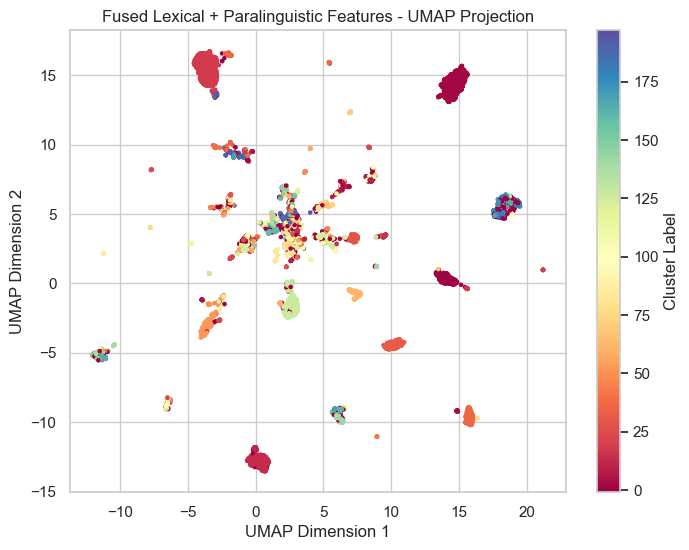

In [107]:
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the Lexical and Paralinguistic Features
scaler = StandardScaler()

bert_scaled = scaler.fit_transform(bert_features_reshaped)  # Lexical features (BERT)
paralinguistic_scaled = scaler.fit_transform(paralinguistic_features)  # Paralinguistic features (from audio)

# Step 2: Concatenate the features
fused_features = np.concatenate((bert_scaled, paralinguistic_scaled), axis=1)

# Step 3: Optionally, reduce the dimensionality of the combined features
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
fused_umap = umap_reducer.fit_transform(fused_features)

# Visualize the fused feature clustering
plt.figure(figsize=(8, 6))
plt.scatter(fused_umap[:, 0], fused_umap[:, 1], c=labels, cmap="Spectral", s=5)
plt.title("Fused Lexical + Paralinguistic Features - UMAP Projection")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

In [108]:
# Step 4: Apply HDBSCAN clustering to fused features
clusterer_fused = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
fused_labels = clusterer_fused.fit_predict(fused_umap)

# Evaluate with Silhouette Score
fused_score = calculate_silhouette(fused_umap, fused_labels)
print(f"Fused Features Silhouette Score: {fused_score:.4f}")

Fused Features Silhouette Score: 0.5904
